# 🧬 VAE: Generowanie przez Morfing

Zwykły Autoenkoder mapuje wejście na sztywny punkt w przestrzeni.
VAE mapuje wejście na **rozkład normalny (Gaussa)**.

**Dlaczego to genialne?**
Dzięki temu przestrzeń ukryta (Latent Space) nie ma "dziur". Każdy punkt w tej przestrzeni, nawet wylosowany, reprezentuje coś sensownego (np. cyfrę, która wygląda jak hybryda 1 i 7).

**Architektura:**
1.  **Encoder:** Zwraca dwa wektory:
    *   $\mu$ (Mu): Średnia (gdzie jest centrum chmury?).
    *   $\sigma$ (Sigma/LogVar): Rozrzut (jak szeroka jest chmura?).
2.  **Sampling (Reparameterization Trick):** Losujemy punkt z tej chmury.
    *   Ten krok jest trudny, bo nie da się policzyć pochodnej z "losowania".
    *   Trik: $z = \mu + \sigma \cdot \epsilon$ (gdzie $\epsilon$ to losowy szum). Przesuwamy losowość na zewnątrz, żeby Autograd działał.
3.  **Decoder:** Odtwarza obrazek z wylosowanego punktu.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Konfiguracja
BATCH_SIZE = 128
LR = 1e-3
EPOCHS = 20
latent_dim = 2 # Zrobimy przestrzeń 2D, żeby móc ją narysować na wykresie!
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dane (MNIST)
dataset = datasets.MNIST(root="data", train=True, transform=transforms.ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Gotowe. Latent Space będzie miał wymiar {latent_dim} (płaska mapa).")

Gotowe. Latent Space będzie miał wymiar 2 (płaska mapa).


## Klasa VAE

To jest serce algorytmu. Zwróć uwagę na metodę `reparameterize`.
To ona pozwala sieci "uczyć się losowości".

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- ENCODER ---
        # Spłaszczamy obrazek 28x28 -> 784
        self.fc1 = nn.Linear(784, 400)
        self.fc2_mu = nn.Linear(400, latent_dim)      # Wektor średnich
        self.fc2_logvar = nn.Linear(400, latent_dim)  # Wektor wariancji (log)

        # --- DECODER ---
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mu(h1), self.fc2_logvar(h1)

    def reparameterize(self, mu, logvar):
        # Trik Reparametryzacji:
        # Nie losujemy z rozkładu N(mu, std).
        # Losujemy eps z N(0, 1) i przesuwamy go o mu i skalujemy przez std.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # Sigmoid, bo piksele są 0-1

    def forward(self, x):
        # 1. Kodowanie do parametrów rozkładu
        mu, logvar = self.encode(x.view(-1, 784))
        
        # 2. Losowanie punktu (z zachowaniem możliwości backprop)
        z = self.reparameterize(mu, logvar)
        
        # 3. Odtwarzanie
        return self.decode(z), mu, logvar

model = VAE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2_mu): Linear(in_features=400, out_features=2, bias=True)
  (fc2_logvar): Linear(in_features=400, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
)


## Funkcja Kosztu (Loss Function)

W VAE funkcja kosztu składa się z dwóch sprzecznych celów:
1.  **Reconstruction Loss (BCE):** "Odtwórz obrazek idealnie". (Ciągnie punkty w różne strony, żeby były dokładne).
2.  **KL Divergence (KLD):** "Utrzymuj przestrzeń ukrytą jako zbitą kulę (rozkład normalny)". (Ściska punkty do środka).

Ta walka sprawia, że przestrzeń jest uporządkowana.

In [3]:
# Specyficzna funkcja kosztu dla VAE
def loss_function(recon_x, x, mu, logvar):
    # 1. Jak bardzo obrazek różni się od oryginału?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. Jak bardzo rozkład różni się od normalnego? (Wzór matematyczny na KLD)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Pętla treningowa
model.train()
for epoch in range(EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(loader):
        data = data.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward
        recon_batch, mu, logvar = model(data)
        
        # Loss
        loss = loss_function(recon_batch, data, mu, logvar)
        
        # Backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print(f"Epoka {epoch+1}: Średni Loss: {train_loss / len(loader.dataset):.4f}")

Epoka 1: Średni Loss: 191.6478
Epoka 2: Średni Loss: 168.9242
Epoka 3: Średni Loss: 164.2105
Epoka 4: Średni Loss: 161.4136
Epoka 5: Średni Loss: 159.4933
Epoka 6: Średni Loss: 158.1203
Epoka 7: Średni Loss: 157.0526
Epoka 8: Średni Loss: 156.0788
Epoka 9: Średni Loss: 155.2489
Epoka 10: Średni Loss: 154.5744
Epoka 11: Średni Loss: 153.9064
Epoka 12: Średni Loss: 153.3639
Epoka 13: Średni Loss: 152.8281
Epoka 14: Średni Loss: 152.3906
Epoka 15: Średni Loss: 151.9826
Epoka 16: Średni Loss: 151.5370
Epoka 17: Średni Loss: 151.1811
Epoka 18: Średni Loss: 150.8498
Epoka 19: Średni Loss: 150.5205
Epoka 20: Średni Loss: 150.1990


## Wizualizacja 1: Mapa Latent Space (2D)

Ponieważ ustawiliśmy `latent_dim=2`, możemy narysować mapę wszystkich cyfr.
Zobaczysz, że cyfry tego samego typu (np. jedynki) grupują się w klastry, a klastry płynnie przechodzą jeden w drugi.

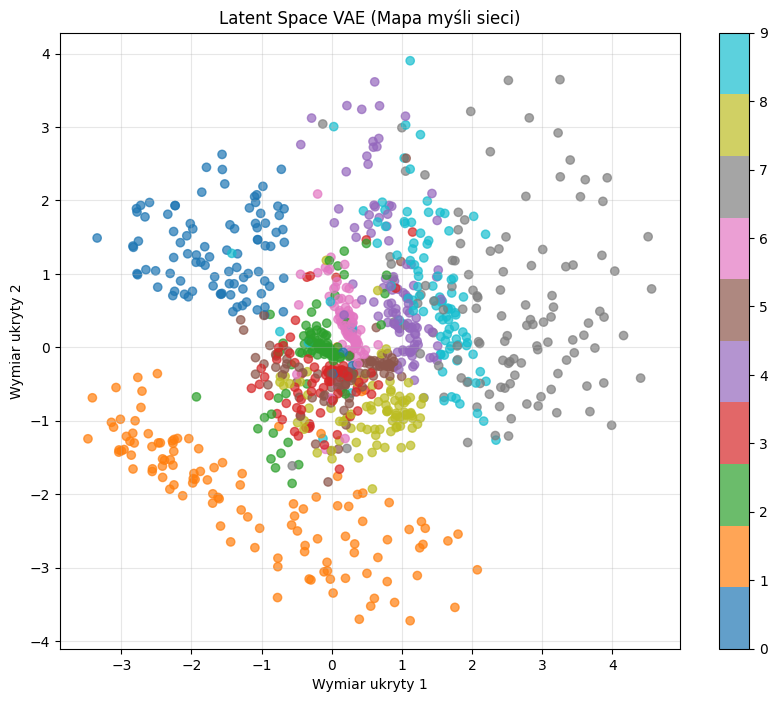

In [4]:
model.eval()
test_loader = DataLoader(dataset, batch_size=1000, shuffle=False) # Bierzemy 1000 próbek

all_z = []
all_labels = []

with torch.no_grad():
    for data, label in test_loader:
        data = data.to(DEVICE)
        mu, logvar = model.encode(data.view(-1, 784))
        # Bierzemy same średnie (centra chmur) do wizualizacji
        all_z.append(mu.cpu().numpy())
        all_labels.append(label.numpy())
        break # Wystarczy jeden duży batch

all_z = np.concatenate(all_z)
all_labels = np.concatenate(all_labels)

plt.figure(figsize=(10, 8))
plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("Latent Space VAE (Mapa myśli sieci)")
plt.xlabel("Wymiar ukryty 1")
plt.ylabel("Wymiar ukryty 2")
plt.grid(True, alpha=0.3)
plt.show()

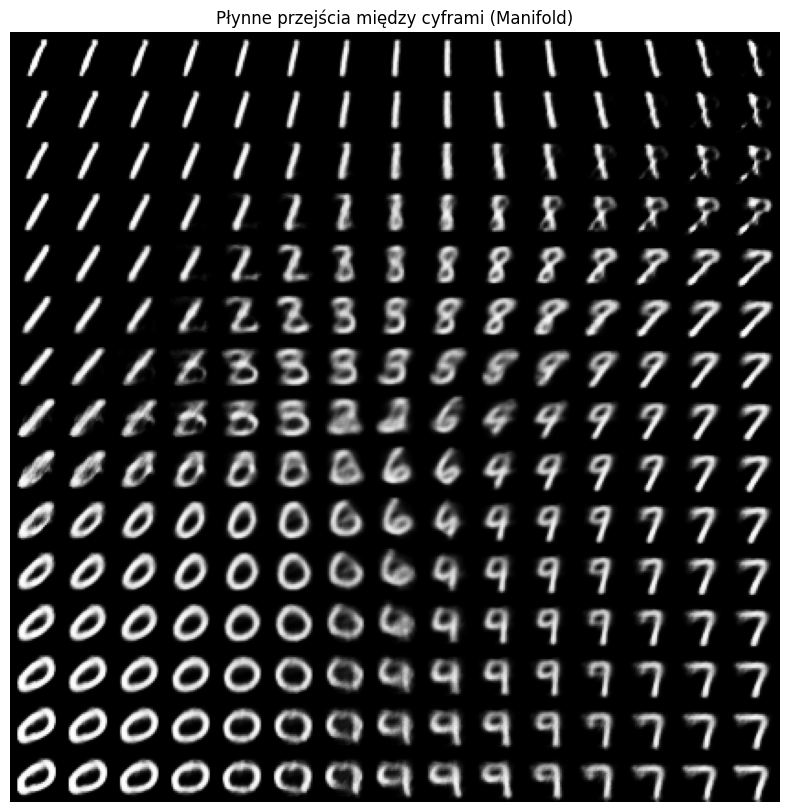

In [5]:
# WIZUALIZACJA 2: Generowanie z niczego (Sampling)
# Losujemy punkty z układu współrzędnych i patrzymy, co "śni" sieć.

n = 15  # Siatka 15x15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Tworzymy siatkę punktów od -3 do 3 (zgodnie z rozkładem normalnym)
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # Punkt w przestrzeni ukrytej
            z_sample = torch.tensor([[xi, yi]]).float().to(DEVICE)
            
            # Dekodowanie
            x_decoded = model.decode(z_sample)
            
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title("Płynne przejścia między cyframi (Manifold)")
plt.axis('off')
plt.show()

## 🧠 Podsumowanie: Ciągłość to klucz

Spójrz na ostatni obrazek (kwadrat).
To nie są losowe cyfry. To jest **mapa**.
*   W jednym rogu są zera.
*   Idąc w prawo, zero powoli zmienia się w szóstkę.
*   Idąc w dół, szóstka zmienia się w ósemkę.

To jest siła VAE. W przeciwieństwie do GAN (który generuje ostre, ale "skaczące" obrazy), VAE rozumie **strukturę** danych.
Dlatego VAE (i jego następcy) są używane w:
*   Kompresji wideo.
*   Wykrywaniu anomalii (jeszcze lepsze niż zwykły AE).
*   Generowaniu nowych cząsteczek leków (interpolacja między znanymi lekami).